In [313]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [314]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [315]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [316]:
df.isnull().sum()

ObservationDate      0
Province/State     982
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [317]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.0,0.0,0.0
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.0,0.0,0.0
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.0,0.0,0.0
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.0,0.0,0.0
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.0,0.0,0.0
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.0,0.0,0.0
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.0,0.0,0.0


In [318]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [319]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,80026
1,South Korea,4335
2,Italy,2036
3,Iran,1501
4,Others,705
5,Japan,274
6,France,191
7,Germany,159
8,Spain,120
9,Singapore,108


In [320]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,Cambodia,1,1
2,Nepal,1,1
3,Sri Lanka,1,1


In [321]:
# Most recent stats
world_daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
world_daily_df = world_daily_df.reset_index()
world_daily_df = world_daily_df.sort_values('ObservationDate', ascending=False)
world_daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602


In [322]:
world_daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602
39,2020-03-01 00:00:00,88371,2996,42716
38,2020-02-29 00:00:00,86013,2941,39782
37,2020-02-28 00:00:00,84124,2872,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886


In [323]:
world_daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [324]:
import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW_SIZE = 4

class PandemicRegressor():
    def __init__(self, window_size, batch_size, n_feature):
        self.window_size = window_size
        self.batch_size = batch_size
        self.n_feature = n_feature
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        self.model_path = os.path.join(save_dir, 'pdm_reg.best.hdf5')
        
        self.callbacks = [
			EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(self.model_path, monitor='val_mape', verbose=0, save_best_only=True, mode='min')
		]
        self.reg = self.build_model()
        
    def build_model(self):
        model = Sequential([
            #LSTM(1024, input_shape=(self.window_size, self.n_feature), dropout=0.5),
            LSTM(64, batch_input_shape=(self.batch_size, self.window_size, self.n_feature), dropout=0.5, stateful=True),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(self.n_feature, activation='linear')
        ])
        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=['mae', 'mape'])
        return model
    
    def fit(self, X_train, y_train, X_val, y_val, epochs=500):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=self.callbacks,
                            verbose=1,
                           shuffle=False)
        return hist
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def load_best_weights(self):
        self.reg.load_weights(self.model_path)
        print('load best weights from ' + self.model_path)
    
    def save(self, name):
        self.reg.save(os.path.join(self.save_dir, name))
        print('saved in ' + os.path.join(self.save_dir, name))
        
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=1, n_feature=3)

In [325]:
"""
Predict the global spread of coronavirus
"""
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Normalize
_mean = np.mean(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)

print(_mean)
print(_std)

[46077.41463415  1313.85365854 11462.34146341]
[31966.13245523  1056.92768198 13683.82920771]


In [326]:
def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)
        return seq_data[:,0:window_size,:], seq_data[:,window_size,:]

In [327]:
X, y = seq2dataset(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X

array([[[  555.,    17.,    28.],
        [  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.]],

       [[  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.]],

       [[  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.]],

       [[ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.]],

       [[ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.]],

       [[ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.]],

       [[ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.],
        [ 9925.,   213.,   222.]],

       [[ 6165.,   133.,   126.],


In [328]:
y

array([[ 2118.,    56.,    52.],
       [ 2927.,    82.,    61.],
       [ 5578.,   131.,   107.],
       [ 6165.,   133.,   126.],
       [ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80

In [329]:
X = (X - _mean) / _std

In [330]:
X

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817]],

       [[-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654]],

       [[-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [332]:
X_train

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817]],

       [[-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654]],

       [[-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-

In [333]:
X_test

array([[[1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238]],

       [[1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512]],

       [[1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255]],

       [[1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.47422228, 1.84514569]],

       [[1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.47422228, 1.84514569],
        [1.24930926, 1.53950584, 2.06957118]],

       [[1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.4

In [334]:
y_train

array([[ 2118.,    56.,    52.],
       [ 2927.,    82.,    61.],
       [ 5578.,   131.,   107.],
       [ 6165.,   133.,   126.],
       [ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80

In [335]:
y_test

array([[81397.,  2770., 30384.],
       [82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86013.,  2941., 39782.],
       [88371.,  2996., 42716.],
       [90309.,  3085., 45602.]])

Train on 31 samples, validate on 6 samples
Epoch 1/1000
31/31 [==============================] - 1s 46ms/step - loss: 959653474.1976 - mae: 17740.2754 - mape: 99.9582 - val_loss: 2934246314.6667 - val_mae: 42156.1953 - val_mape: 99.9617
Epoch 2/1000
31/31 [==============================] - 0s 10ms/step - loss: 708341039.4556 - mae: 14914.5859 - mape: 62.0090 - val_loss: 1611980010.6667 - val_mae: 30855.9219 - val_mape: 63.8693
Epoch 3/1000
31/31 [==============================] - 0s 10ms/step - loss: 282593605.0968 - mae: 11731.8848 - mape: 1334.6331 - val_loss: 432504920.0000 - val_mae: 16880.1523 - val_mape: 38.2916
Epoch 4/1000
31/31 [==============================] - 0s 9ms/step - loss: 547364983.5806 - mae: 15853.8662 - mape: 1549.2673 - val_loss: 945849450.6667 - val_mae: 25234.1328 - val_mape: 65.7745
Epoch 5/1000
31/31 [==============================] - 0s 10ms/step - loss: 319963178.8065 - mae: 11819.8877 - mape: 813.0383 - val_loss: 738123717.3333 - val_mae: 22327.9160 - val_

31/31 [==============================] - 0s 10ms/step - loss: 95775586.2661 - mae: 5691.9902 - mape: 309.5423 - val_loss: 139733956.6667 - val_mae: 7756.3862 - val_mape: 33.7384
Epoch 44/1000
31/31 [==============================] - 0s 10ms/step - loss: 251219010.5323 - mae: 9519.1328 - mape: 768.7057 - val_loss: 262727266.6667 - val_mae: 12674.6318 - val_mape: 29.2290
Epoch 45/1000
31/31 [==============================] - 0s 10ms/step - loss: 49409299.4093 - mae: 4718.9595 - mape: 316.3577 - val_loss: 156147445.3333 - val_mae: 9610.8184 - val_mape: 29.0017
Epoch 46/1000
31/31 [==============================] - 0s 10ms/step - loss: 109958629.0403 - mae: 6447.0503 - mape: 502.5752 - val_loss: 152612538.0000 - val_mae: 7907.5796 - val_mape: 28.6730
Epoch 47/1000
31/31 [==============================] - 0s 10ms/step - loss: 130485286.1915 - mae: 5915.8057 - mape: 616.7399 - val_loss: 133726303.3333 - val_mae: 7207.7441 - val_mape: 18.0848
Epoch 48/1000
31/31 [=============================

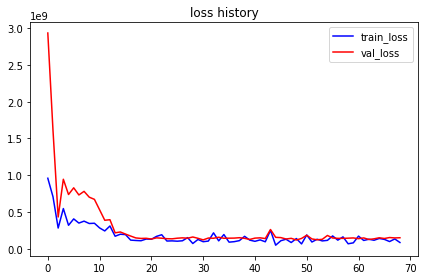

load best weights from C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-04;23.05.46\pdm_reg.best.hdf5
6/6 [==============================] - 0s 5ms/step
MAE: 7209.80126953125, MAPE: 17.576051712036133
Train is done..


In [336]:
hist = pdm_reg.fit(X_train=X_train, 
                       y_train=y_train, 
                       X_val=X_test, 
                       y_val=y_test,
                       epochs=1000)

show_train_hist(hist)

pdm_reg.load_best_weights()

loss_and_metrics = pdm_reg.evaluate(X_test=X_test, 
                     y_test=y_test)
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')

print('Train is done..')

In [337]:
nation_df = df[df['Country/Region'] == 'South Korea'].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
nation_df = nation_df.reset_index()
nation_df = nation_df.sort_values('ObservationDate', ascending=False)
nation_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,4335,28,30
39,2020-03-01 00:00:00,3736,17,30
38,2020-02-29 00:00:00,3150,16,27
37,2020-02-28 00:00:00,2337,13,22
36,2020-02-27 00:00:00,1766,13,22
35,2020-02-26 00:00:00,1261,12,22
34,2020-02-25 00:00:00,977,10,22
33,2020-02-24 00:00:00,833,8,18
32,2020-02-23 00:00:00,602,6,18
31,2020-02-22 00:00:00,433,2,16


In [338]:
print(df['Country/Region'].unique())

['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal']


[South Korea spread of coronavirus19]
Train on 31 samples, validate on 6 samples
Epoch 1/300
31/31 [==============================] - 0s 10ms/step - loss: 228905647.3548 - mae: 10026.8682 - mape: 1044365246464.0000 - val_loss: 494681226.6667 - val_mae: 15377.4189 - val_mape: 12145.5312
Epoch 2/300
31/31 [==============================] - 0s 9ms/step - loss: 42501594.0806 - mae: 4331.9902 - mape: 320817201152.0000 - val_loss: 131837045.3333 - val_mae: 7845.5288 - val_mape: 5848.5776
Epoch 3/300
31/31 [==============================] - 0s 10ms/step - loss: 14939773.2419 - mae: 2555.4277 - mape: 193670643712.0000 - val_loss: 16940793.8333 - val_mae: 2881.2048 - val_mape: 2501.7463
Epoch 4/300
31/31 [==============================] - 0s 10ms/step - loss: 1247243.5842 - mae: 545.0107 - mape: 71478509568.0000 - val_loss: 933356.8438 - val_mae: 612.1878 - val_mape: 328.0159
Epoch 5/300
31/31 [==============================] - 0s 10ms/step - loss: 39768.7971 - mae: 78.0026 - mape: 7836083200.0

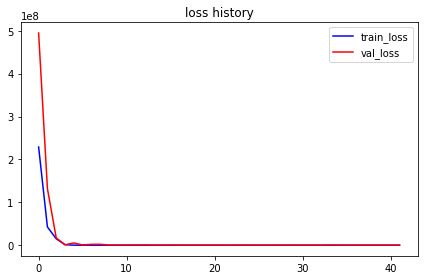

6/6 [==============================] - 0s 4ms/step
MAE: 372.02978515625, MAPE: 187.2680206298828
Train is done..


In [339]:
# for nation_name in df['Country/Region'].unique():
# pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=1)

for nation_name in ['South Korea']:
    nation_df = df[df['Country/Region'] == nation_name].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
    nation_df = nation_df.reset_index()
    nation_df = nation_df.sort_values('ObservationDate', ascending=False)
    
    print(f'[{nation_name} spread of coronavirus19]')
    
    # Normalize
    _mean = np.mean(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    _std = np.std(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    
    X, y = seq2dataset(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
    X = (X - _mean) / _std
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
        
    hist = pdm_reg.fit(X_train=X_train, 
                       y_train=y_train, 
                       X_val=X_test, 
                       y_val=y_test,
                       epochs=300)

    show_train_hist(hist)
    loss_and_metrics = pdm_reg.evaluate(X_test=X_test, 
                                            y_test=y_test)
    print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
       
print('Train is done..')

In [340]:
pdm_reg.save()

TypeError: save() missing 1 required positional argument: 'name'